In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev,opt_prob_metrics_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from scipy.stats import rankdata

# Datasets

In [2]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["dev", "test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 52864/52864 [00:28<00:00, 1887.66it/s]


In [3]:
dataset_lp_and_noise = dataset.filter(
    (dataset.metadata["source_type"] == "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_rg_and_noise = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
print("Number of traces in the test set and the development set:")
print(f"{len(dataset_lp_and_noise)} lp and noise traces")
print(f"{len(dataset_rg_and_noise)} vt and noise traces")

print(f"""{len(dataset.metadata[dataset.metadata["source_type"]=="lp"])} lp traces""")
print(
    f"""{len(dataset.metadata[(dataset.metadata["source_type"]!="lp")&(dataset.metadata["source_type"]!="noise")])} regular earthquake traces"""
)
print(
    f"""{len(dataset.metadata[dataset.metadata["source_type"]=="noise"])} noise earthquake traces"""
)

Number of traces in the test set and the development set:
30168 lp and noise traces
30235 vt and noise traces
22629 lp traces
22696 regular earthquake traces
7539 noise earthquake traces


Evaluation target

In [8]:
# full data set
targets_path_lp_and_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/all"
)
try:
    targets_path_lp_and_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg} exists")

# LP and noise
targets_path_lp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise"
)
try:
    targets_path_lp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp} exists")

# VT and noise
targets_path_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise"
)
try:
    targets_path_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/all exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise exists


# Models

In [4]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights_testsize")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

['e_frac0.300',
 'p_frac0.050',
 'e_frac0.700',
 'e_frac0.900',
 'e_frac0.100',
 'e_frac0.500',
 'p_frac0.500',
 'p_frac0.300',
 'p_frac0.100',
 'p_frac0.900',
 'e_frac0.050',
 'p_frac0.700']

True
0.0164543502032756
/home/zhongyiyuan/volpick/model_training/weights_testsize/e_frac0.300/version_0
True
0.0556819401681423
/home/zhongyiyuan/volpick/model_training/weights_testsize/p_frac0.050/version_1
True
0.0158951729536056
/home/zhongyiyuan/volpick/model_training/weights_testsize/e_frac0.700/version_0
True
0.0156836528331041
/home/zhongyiyuan/volpick/model_training/weights_testsize/e_frac0.900/version_0
True
0.0176290310919284
/home/zhongyiyuan/volpick/model_training/weights_testsize/e_frac0.100/version_0
True
0.0163041800260543
/home/zhongyiyuan/volpick/model_training/weights_testsize/e_frac0.500/version_0
True
0.0429339297115802
/home/zhongyiyuan/volpick/model_training/weights_testsize/p_frac0.500/version_0
True
0.0442850813269615
/home/zhongyiyuan/volpick/model_training/weights_testsize/p_frac0.300/version_0
True
0.0473995953798294
/home/zhongyiyuan/volpick/model_training/weights_testsize/p_frac0.100/version_0
True
0.0426044687628746
/home/zhongyiyuan/volpick/model_training

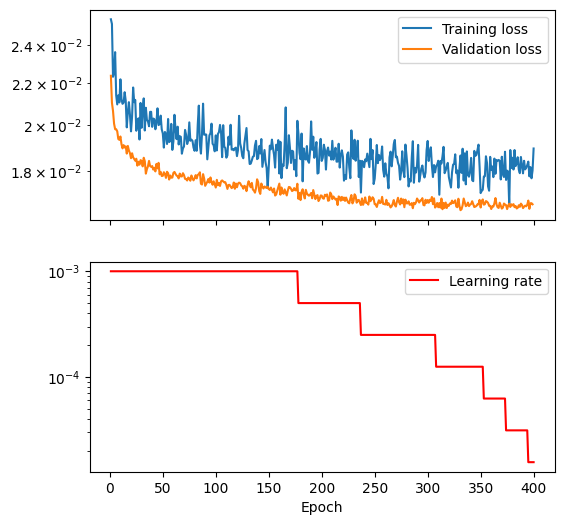

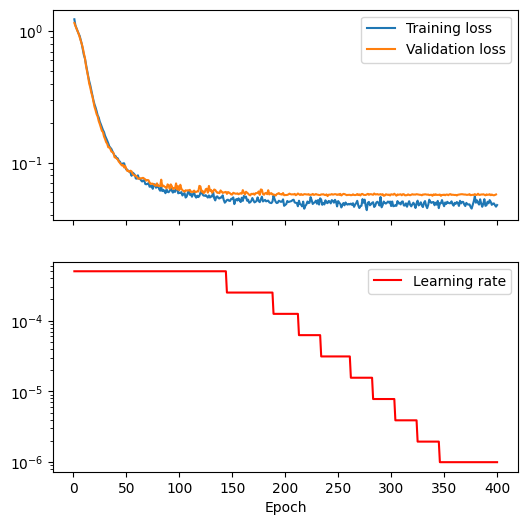

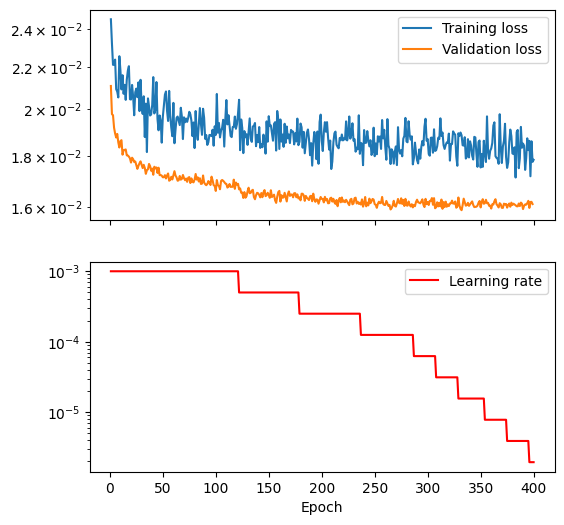

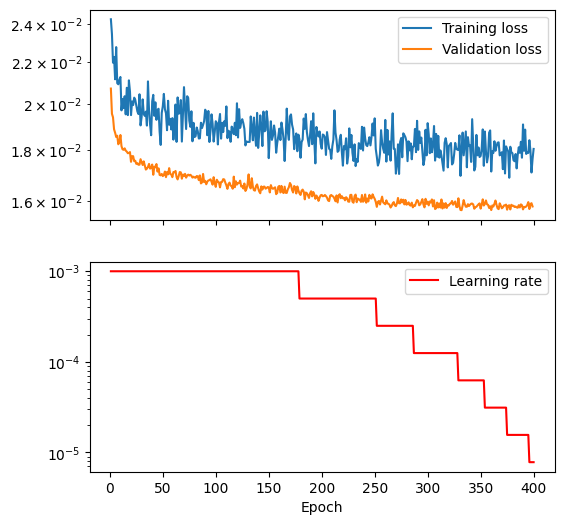

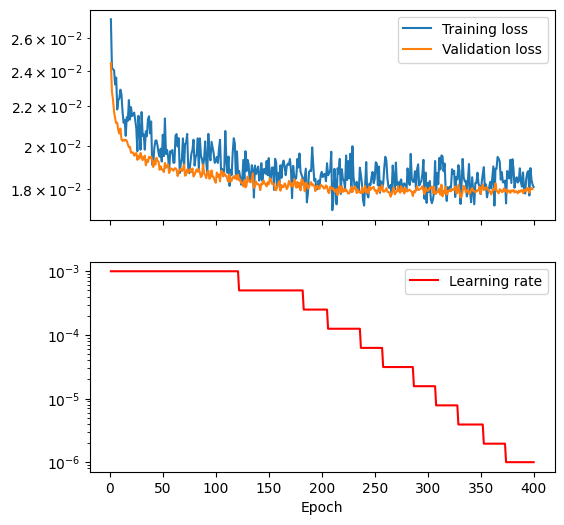

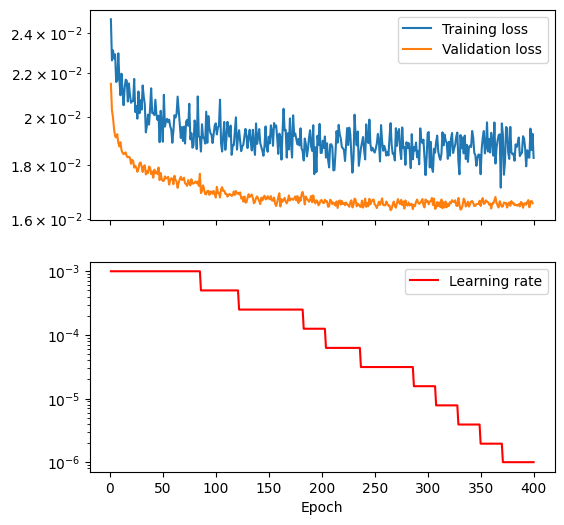

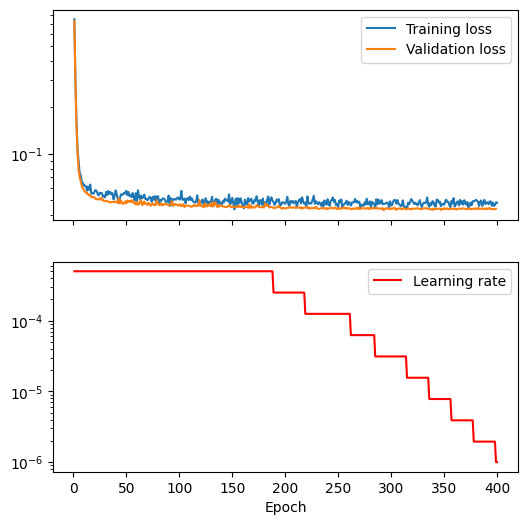

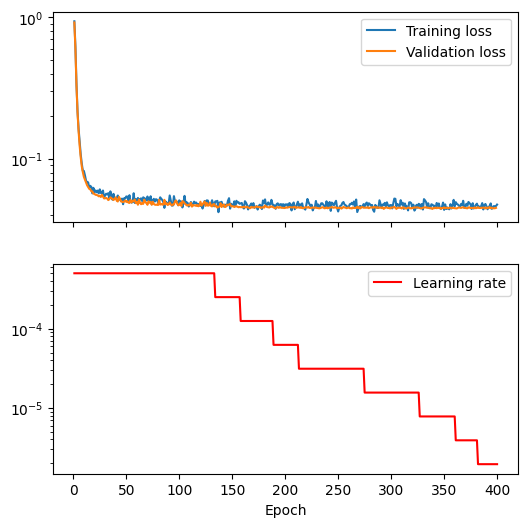

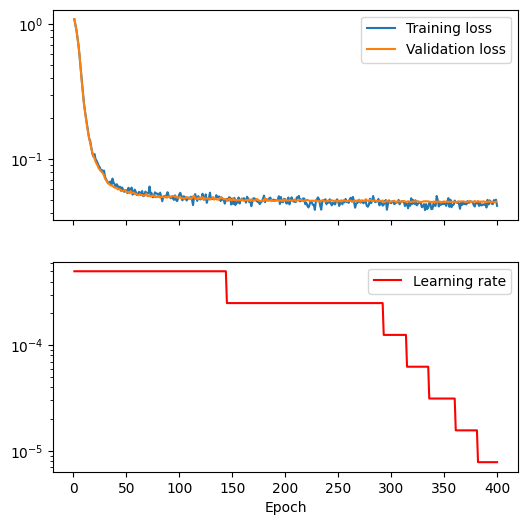

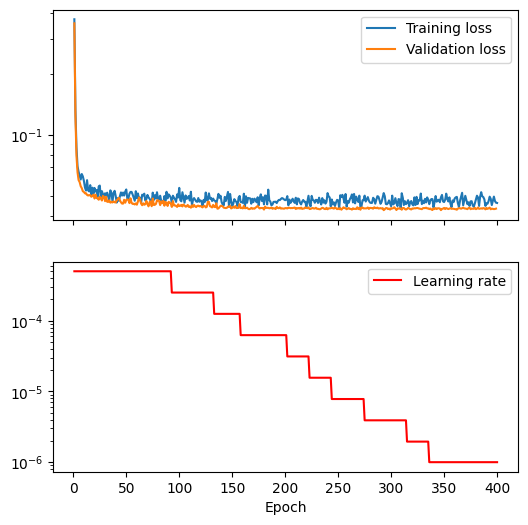

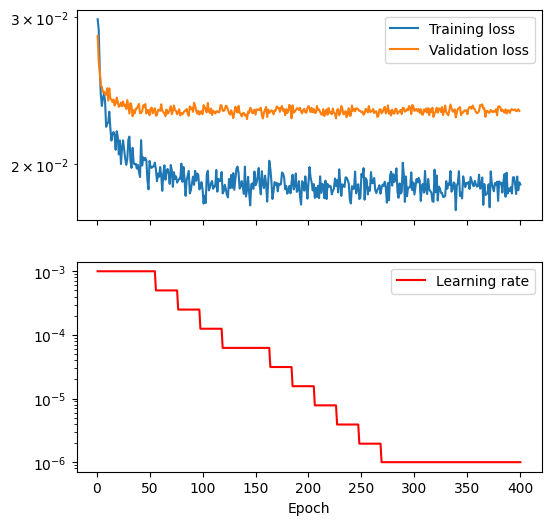

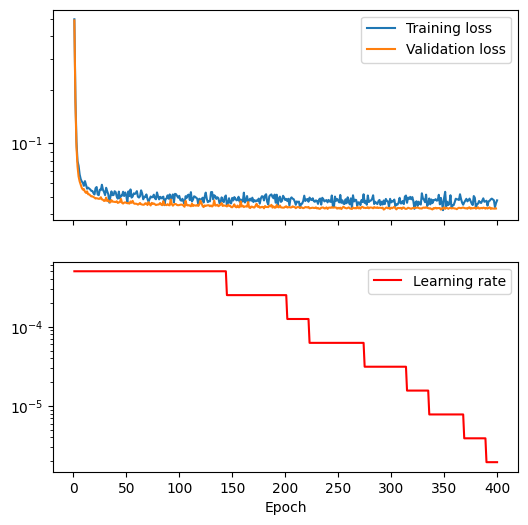

In [6]:
for model_dirname in model_dirs:
    model_path = (
        Path("/home/zhongyiyuan/volpick/model_training/weights_testsize")
        / model_dirname
    )
    pl_model = load_best_model_from_base_dir(model_path)

# Threshold

In [10]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset]

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model = load_best_model_from_base_dir(model_path, plot_loss=False)
    model = pl_model.model
    for target_i, dataset_i in zip(target_path_list, dataset_list):
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"{model_path.name}",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_diffsize",
            # prob_thres=np.array([0.27,0.3,0.32]),
            # prob_thres=np.array([0.13,0.15,0.17,0.20,0.22,0.23,0.24,0.25,0.26,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
            prob_thres=np.arange(0.12, 0.42, 0.01),
            num_workers=32,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.300 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 346655.10it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 350836.89it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.700 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 354206.43it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.900 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 358646.11it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.100 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 359786.95it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.500 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 357376.86it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.500 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 350995.73it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.300 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 363207.36it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.100 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 357827.04it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.900 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 365112.15it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.050 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 359127.22it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.700 exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 358796.54it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100


In [14]:
target_path_list

[PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_targets/all')]

In [15]:
pred_dirs

[PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred')]

In [45]:
def collect_task0_results_diff_training_sizes_dev(
    pred_dir: Path,
    output_fname: str = "task0_metrics_sum_dev.csv",
    parse_exp_name: bool = True,
) -> pd.DataFrame:
    exp_names = [
        x
        for x in pred_dir.iterdir()
        if x.is_dir() and x.name != "task123" and (x / "dev_metrics.csv").exists()
    ]
    # print(exp_names)
    metrics_data = []
    for exp_dir in exp_names:
        print(exp_dir.name)
        stats = opt_prob_metrics_dev(exp_dir)
        # det_stats = parse_task0_detection(exp_dir, only_dev=True)
        # stats.update(det_stats)
        metrics_data.append(stats)

    df = pd.DataFrame(metrics_data)
    df.sort_values(by=["tp_thre"], ignore_index=True, inplace=True)

    if parse_exp_name:
        # model_names = {"ve": "voleqtransformer", "e": "eqtransformer", "p": "phasenet"}
        model_names = {"e": "eqtransformer", "p": "phasenet"}
        df.insert(
            1, "model", df["exp_name"].apply(lambda x: model_names[x.split("_")[0]])
        )
        df.insert(
            2, "training_fraction", df["exp_name"].apply(lambda x: x.split("_")[1][4:])
        )

    df.sort_values(by=["model", "training_fraction"], ignore_index=True, inplace=True)
    df.to_csv(pred_dir / output_fname, index=False)
    return df

In [46]:
pred_dir

PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred')

In [47]:
root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Eval_diffsize")

pred_dirs = [root_save_dir / f"{x.name}_pred" for x in target_path_list]
for pred_dir in pred_dirs:
    print(pred_dir / "task0")
    collect_task0_results_diff_training_sizes_dev(pred_dir / "task0")

df0 = pd.read_csv(root_save_dir / "all_pred/task0/task0_metrics_sum_dev.csv")

/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0
e_frac1.000
p_frac1.000
e_frac0.300
p_frac0.050
e_frac0.700
e_frac0.900
e_frac0.100
e_frac0.500
p_frac0.500
p_frac0.300
p_frac0.100
p_frac0.900
e_frac0.050
p_frac0.700


In [58]:
df0[
    [
        "exp_name",
        "p_opt_prob_thre",
        "s_opt_prob_thre",
        "dev_p_precision",
        "dev_p_recall",
        "dev_p_F1score",
        "dev_s_precision",
        "dev_s_recall",
        "dev_s_F1score",
    ]
]

,exp_name,p_opt_prob_thre,s_opt_prob_thre,dev_p_precision,dev_p_recall,dev_p_F1score,dev_s_precision,dev_s_recall,dev_s_F1score
0,e_frac0.050,0.28,0.23,0.911102,0.891968,0.901434,0.864222,0.865366,0.864793
1,e_frac0.100,0.21,0.21,0.911044,0.915602,0.913318,0.872221,0.877631,0.874918
2,e_frac0.300,0.25,0.21,0.924385,0.915866,0.920106,0.879848,0.889965,0.884878
3,e_frac0.500,0.25,0.20,0.922934,0.917709,0.920314,0.878433,0.893798,0.886049
4,e_frac0.700,0.20,0.24,0.918152,0.926070,0.922094,0.889113,0.888990,0.889052
5,e_frac0.900,0.25,0.20,0.928657,0.922910,0.925774,0.884668,0.899094,0.891823
6,e_frac1.000,0.22,0.22,0.923941,0.926070,0.925004,0.887852,0.895401,0.891611
7,p_frac0.050,0.37,0.36,0.880070,0.861356,0.870613,0.837310,0.831359,0.834324
8,p_frac0.100,0.38,0.37,0.902626,0.878144,0.890216,0.857679,0.844530,0.851053
9,p_frac0.300,0.34,0.33,0.907303,0.907900,0.907601,0.874190,0.874007,0.874098


In [24]:
thre_dict = {}
for i in range(len(df0)):
    row = df0.iloc[i]
    thre_dict[row["exp_name"]] = np.unique(
        [row["p_opt_prob_thre"], row["s_opt_prob_thre"]]
    )

In [29]:
thre_dict

{'e_frac0.050': array([0.23, 0.28]),
 'e_frac0.100': array([0.21]),
 'e_frac0.300': array([0.21, 0.25]),
 'e_frac0.500': array([0.2 , 0.25]),
 'e_frac0.700': array([0.2 , 0.24]),
 'e_frac0.900': array([0.2 , 0.25]),
 'p_frac0.050': array([0.36, 0.37]),
 'p_frac0.100': array([0.37, 0.38]),
 'p_frac0.300': array([0.33, 0.34]),
 'p_frac0.500': array([0.33, 0.39]),
 'p_frac0.700': array([0.35, 0.38]),
 'p_frac0.900': array([0.32, 0.34])}

In [23]:
for model_dirname in model_dirs:
    print(model_dirname)

e_frac0.300
p_frac0.050
e_frac0.700
e_frac0.900
e_frac0.100
e_frac0.500
p_frac0.500
p_frac0.300
p_frac0.100
p_frac0.900
e_frac0.050
p_frac0.700


In [41]:
thre_dict

{'e_frac0.050': array([0.23, 0.28]),
 'e_frac0.100': array([0.21]),
 'e_frac0.300': array([0.21, 0.25]),
 'e_frac0.500': array([0.2 , 0.25]),
 'e_frac0.700': array([0.2 , 0.24]),
 'e_frac0.900': array([0.2 , 0.25]),
 'p_frac0.050': array([0.36, 0.37]),
 'p_frac0.100': array([0.37, 0.38]),
 'p_frac0.300': array([0.33, 0.34]),
 'p_frac0.500': array([0.33, 0.39]),
 'p_frac0.700': array([0.35, 0.38]),
 'p_frac0.900': array([0.32, 0.34])}

In [30]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset]

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model = load_best_model_from_base_dir(model_path, plot_loss=False)
    model = pl_model.model
    for target_i, dataset_i in zip(target_path_list, dataset_list):
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"{model_path.name}",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_diffsize",
            # prob_thres=np.array([0.27,0.3,0.32]),
            # prob_thres=np.array([0.13,0.15,0.17,0.20,0.22,0.23,0.24,0.25,0.26,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
            prob_thres=thre_dict[model_dirname],
            num_workers=32,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["test"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.300 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 347480.55it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2100
Probability threshold: 0.2500
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.050 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 362788.14it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.3600
Probability threshold: 0.3700
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.700 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 353152.89it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2000
Probability threshold: 0.2400
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.900 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 367004.74it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2000
Probability threshold: 0.2500
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.100 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 341386.78it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2100
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.500 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 341914.52it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2000
Probability threshold: 0.2500
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.500 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 342321.35it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.3300
Probability threshold: 0.3900
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.300 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 365420.57it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.3300
Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.100 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 363428.11it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.3700
Probability threshold: 0.3800
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.900 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 362358.88it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.3200
Probability threshold: 0.3400
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/e_frac0.050 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 343357.06it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.2300
Probability threshold: 0.2800
/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0/p_frac0.700 exists
Starting set: test


Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 344033.89it/s]


Number of examples in test: 35120
30135 earthquake traces
4985 noise traces
Probability threshold: 0.3500
Probability threshold: 0.3800


In [60]:
a = {"p": 0}
b = {"s": 1}
{**a, **b}

{'p': 0, 's': 1}

In [77]:
def collect_task0_results_diff_training_sizes_test(
    pred_dir: Path,
    output_fname: str = "task0_metrics_sum_test.csv",
    parse_exp_name: bool = True,
) -> pd.DataFrame:
    exp_names = [
        x
        for x in pred_dir.iterdir()
        if x.is_dir() and x.name != "task123" and (x / "test_metrics.csv").exists()
    ]
    # print(exp_names)
    metrics_data = []
    for exp_dir in exp_names:
        print(exp_dir.name)
        stats = opt_prob_metrics_dev(exp_dir)
        # det_stats = parse_task0_detection(exp_dir, only_dev=True)
        # stats.update(det_stats)
        p_opt_prob_thre = stats["p_opt_prob_thre"]
        s_opt_prob_thre = stats["s_opt_prob_thre"]

        test_metrics = pd.read_csv(exp_dir / "test_metrics.csv")
        p_row = (
            test_metrics[np.isclose(test_metrics["prob_thre"], p_opt_prob_thre)]
            .iloc[0][[x for x in list(test_metrics.columns) if x[0:2] == "p_"]]
            .to_dict()
        )
        s_row = (
            test_metrics[np.isclose(test_metrics["prob_thre"], s_opt_prob_thre)]
            .iloc[0][[x for x in list(test_metrics.columns) if x[0:2] == "s_"]]
            .to_dict()
        )
        row = {**p_row, **s_row}
        row["p_opt_prob_thre"] = p_opt_prob_thre
        row["s_opt_prob_thre"] = s_opt_prob_thre
        row["exp_name"] = exp_dir.name
        metrics_data.append(row)

    df = pd.DataFrame(metrics_data)
    # df.sort_values(by=["tp_thre"], ignore_index=True, inplace=True)

    if parse_exp_name:
        # model_names = {"ve": "voleqtransformer", "e": "eqtransformer", "p": "phasenet"}
        model_names = {"e": "eqtransformer", "p": "phasenet"}
        df.insert(
            1, "model", df["exp_name"].apply(lambda x: model_names[x.split("_")[0]])
        )
        df.insert(
            2, "training_fraction", df["exp_name"].apply(lambda x: x.split("_")[1][4:])
        )

    df.sort_values(by=["model", "training_fraction"], ignore_index=True, inplace=True)
    df.to_csv(pred_dir / output_fname, index=False)
    return df

In [78]:
root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Eval_diffsize")

pred_dirs = [root_save_dir / f"{x.name}_pred" for x in target_path_list]
for pred_dir in pred_dirs:
    print(pred_dir / "task0")
    collect_task0_results_diff_training_sizes_test(pred_dir / "task0")

df1 = pd.read_csv(root_save_dir / "all_pred/task0/task0_metrics_sum_test.csv")

/home/zhongyiyuan/volpick/model_training/Eval_diffsize/all_pred/task0
e_frac1.000
p_frac1.000
e_frac0.300
p_frac0.050
e_frac0.700
e_frac0.900
e_frac0.100
e_frac0.500
p_frac0.500
p_frac0.300
p_frac0.100
p_frac0.900
e_frac0.050
p_frac0.700


In [79]:
df1.columns

Index(['p_TP', 'model', 'training_fraction', 'p_FP', 'p_FN', 'p_precision',
       'p_recall', 'p_F1score', 'p_mean', 'p_median', 'p_std', 'p_MAE',
       'p_MAD', 'p_out', 'p_modified_mean', 'p_modified_median',
       'p_modified_std', 'p_modified_RMSE', 'p_modified_MAE', 'p_modified_MAD',
       'p_modified_mean2', 'p_modified_median2', 'p_modified_std2',
       'p_modified_RMSE2', 'p_modified_MAE2', 'p_modified_MAD2', 's_TP',
       's_FP', 's_FN', 's_precision', 's_recall', 's_F1score', 's_mean',
       's_median', 's_std', 's_MAE', 's_MAD', 's_out', 's_modified_mean',
       's_modified_median', 's_modified_std', 's_modified_RMSE',
       's_modified_MAE', 's_modified_MAD', 's_modified_mean2',
       's_modified_median2', 's_modified_std2', 's_modified_RMSE2',
       's_modified_MAE2', 's_modified_MAD2', 'p_opt_prob_thre',
       's_opt_prob_thre', 'exp_name'],
      dtype='object')

In [82]:
df1

,p_TP,model,training_fraction,p_FP,p_FN,p_precision,p_recall,p_F1score,p_mean,p_median,...,s_modified_MAD,s_modified_mean2,s_modified_median2,s_modified_std2,s_modified_RMSE2,s_modified_MAE2,s_modified_MAD2,p_opt_prob_thre,s_opt_prob_thre,exp_name
0,26905.0,eqtransformer,0.05,2665.0,3230.0,0.909875,0.892816,0.901265,-0.038048,-0.01,...,0.09,0.024644,0.02,0.219501,0.220876,0.141446,0.08,0.28,0.23,e_frac0.050
1,27603.0,eqtransformer,0.10,2675.0,2532.0,0.911652,0.915978,0.913810,-0.042662,0.00,...,0.09,0.032663,0.03,0.216604,0.219049,0.141640,0.08,0.21,0.21,e_frac0.100
2,27655.0,eqtransformer,0.30,2221.0,2480.0,0.925659,0.917704,0.921664,-0.115400,0.00,...,0.08,0.028400,0.03,0.204903,0.206858,0.132183,0.07,0.25,0.21,e_frac0.300
3,27666.0,eqtransformer,0.50,2244.0,2469.0,0.924975,0.918069,0.921509,-0.127594,-0.01,...,0.08,0.025778,0.02,0.201770,0.203406,0.129429,0.07,0.25,0.20,e_frac0.500
4,27991.0,eqtransformer,0.70,2364.0,2144.0,0.922122,0.928853,0.925475,-0.129343,0.00,...,0.08,0.026377,0.02,0.196847,0.198602,0.125788,0.07,0.20,0.24,e_frac0.700
5,27850.0,eqtransformer,0.90,2058.0,2285.0,0.931189,0.924175,0.927669,-0.136194,0.00,...,0.08,0.024038,0.02,0.197223,0.198679,0.124857,0.07,0.25,0.20,e_frac0.900
6,27962.0,eqtransformer,1.00,2212.0,2173.0,0.926692,0.927891,0.927291,-0.127411,0.00,...,0.08,0.023993,0.02,0.197060,0.198512,0.125100,0.07,0.22,0.22,e_frac1.000
7,25983.0,phasenet,0.05,3498.0,4152.0,0.881347,0.862220,0.871679,0.100746,0.00,...,0.08,0.008072,0.00,0.220838,0.220981,0.133925,0.07,0.37,0.36,p_frac0.050
8,26535.0,phasenet,0.10,2766.0,3600.0,0.905600,0.880538,0.892893,0.099988,-0.01,...,0.08,0.009413,0.00,0.210481,0.210687,0.127713,0.07,0.38,0.37,p_frac0.100
9,27403.0,phasenet,0.30,2674.0,2732.0,0.911095,0.909341,0.910217,0.079643,0.00,...,0.07,0.005621,0.00,0.204539,0.204612,0.119936,0.06,0.34,0.33,p_frac0.300


In [90]:
df1[
    [
        "exp_name",
        "model",
        "training_fraction",
        "p_opt_prob_thre",
        "s_opt_prob_thre",
        "p_precision",
        "p_recall",
        "p_F1score",
        "s_precision",
        # "p_modified_RMSE2",
        "s_recall",
        "s_F1score",
        # "s_modified_RMSE2",
    ]
]

,exp_name,model,training_fraction,p_opt_prob_thre,s_opt_prob_thre,p_precision,p_recall,p_F1score,s_precision,s_recall,s_F1score
0,e_frac0.050,eqtransformer,0.05,0.28,0.23,0.909875,0.892816,0.901265,0.865330,0.869948,0.867633
1,e_frac0.100,eqtransformer,0.10,0.21,0.21,0.911652,0.915978,0.913810,0.872942,0.880728,0.876818
2,e_frac0.300,eqtransformer,0.30,0.25,0.21,0.925659,0.917704,0.921664,0.884105,0.893262,0.888660
3,e_frac0.500,eqtransformer,0.50,0.25,0.20,0.924975,0.918069,0.921509,0.884320,0.898634,0.891420
4,e_frac0.700,eqtransformer,0.70,0.20,0.24,0.922122,0.928853,0.925475,0.896130,0.893613,0.894870
5,e_frac0.900,eqtransformer,0.90,0.25,0.20,0.931189,0.924175,0.927669,0.890726,0.904112,0.897369
6,e_frac1.000,eqtransformer,1.00,0.22,0.22,0.926692,0.927891,0.927291,0.894663,0.900004,0.897325
7,p_frac0.050,phasenet,0.05,0.37,0.36,0.881347,0.862220,0.871679,0.840087,0.837049,0.838566
8,p_frac0.100,phasenet,0.10,0.38,0.37,0.905600,0.880538,0.892893,0.861532,0.849584,0.855516
9,p_frac0.300,phasenet,0.30,0.34,0.33,0.911095,0.909341,0.910217,0.874484,0.878445,0.876460


In [94]:
subdf["p_precision"]

0    0.909875
1    0.911652
2    0.925659
3    0.924975
4    0.922122
5    0.931189
6    0.926692
Name: p_precision, dtype: float64

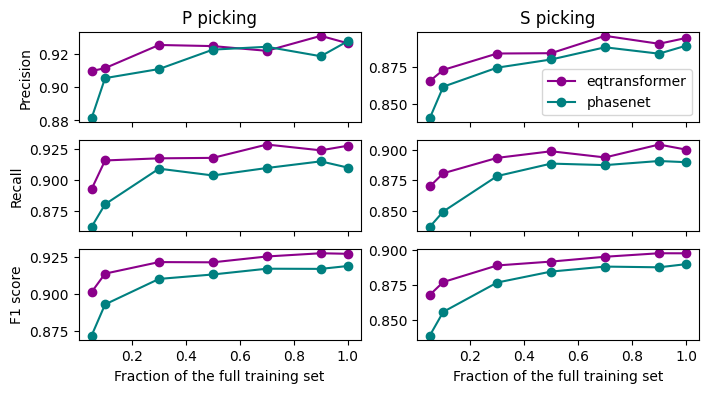

In [136]:
fig, axs = plt.subplots(3, 2, figsize=(8, 4), sharex=True)
color_dict = {"eqtransformer": "darkmagenta", "phasenet": "teal"}
ylabels = {"precision": "Precision", "recall": "Recall", "F1score": "F1 score"}
for j, modelname in enumerate(["eqtransformer", "phasenet"]):
    subdf = df1[df1["model"] == modelname]
    for i, metric in enumerate(["precision", "recall", "F1score"]):
        axs[i][0].plot(
            subdf["training_fraction"],
            subdf[f"p_{metric}"],
            color=color_dict[modelname],
            marker="o",
            label=modelname,
        )
        axs[i][1].plot(
            subdf["training_fraction"],
            subdf[f"s_{metric}"],
            color=color_dict[modelname],
            marker="o",
            label=modelname,
        )
        axs[i][0].set_ylabel(ylabels[metric])
axs[0][-1].legend()
axs[0][0].set_title("P picking")
axs[0][1].set_title("S picking")
axs[-1][0].set_xlabel("Fraction of the full training set")
axs[-1][1].set_xlabel("Fraction of the full training set")
plt.savefig(
    "metrics_vs_trainingSetSize.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.savefig(
    "metrics_vs_trainingSetSize.jpg", dpi=600, bbox_inches="tight", pad_inches=0
)